<a href="https://colab.research.google.com/github/santisis/frs22/blob/master/practico1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fundamentos del recurso solar 2022
Práctico 1 -- Radiación solar
=============================

Sebastián Santisi <ssantisi@csc.conicet.gov.ar>

In [1]:
from math import pi, exp, sin, cos, acos, asin, tan, atan2, radians, degrees, copysign

import pandas

import matplotlib.pyplot as plt
import matplotlib.patches

plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = figsize = (10, 5)

!wget --no-cache --backups=1 https://raw.githubusercontent.com/santisis/frs22/master/LB_2018_completo.csv

--2022-04-18 22:29:28--  https://raw.githubusercontent.com/santisis/frs22/master/LB_2018_completo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1010101 (986K) [text/plain]
Failed to rename LB_2018_completo.csv to LB_2018_completo.csv.1: (2) No such file or directory
Saving to: ‘LB_2018_completo.csv’

LB_2018_completo.cs 100%[===================>] 986.43K  --.-KB/s    in 0.06s   

2022-04-18 22:29:30 (17.3 MB/s) - ‘LB_2018_completo.csv’ saved [1010101/1010101]



Ejercicio 0 -- Parte a
----------------------

Implementación:

In [2]:
GS = 1361 # W/m2
IS = 4.9  # MJ/m2

def factor_correccion_orbital(n):
  """Fn, órbita elíptica
  n es el día ordinal"""
  epsilon = 0.01671123
  phi = 2 * pi * n / 365

  return (1 + epsilon * cos(phi)) ** 2 / (1 - epsilon ** 2)

def factor_correccion_orbital_spencer(n):
  """Fn, por parametrización de Spencer
  n es el día ordinal"""
  gamma = 2 * pi * (n - 1) / 365
  return 1.000110 + 0.034221 * cos(gamma) + 0.001280 * sin(gamma) + \
    0.000719 * cos(2 * gamma) + 0.000077 * sin(2 * gamma)

def declinacion_solar(n):
  """$\delta$, parametrización de Cooper
  n es el día ordinal"""
  return 0.409 * sin(2 * pi * (284 + n) / 365)

def declinacion_solar_spencer(n):
  """$\delta$, parametrización de Spencer
  n es el día ordinal"""
  gamma = 2 * pi * (n - 1) / 365
  return 0.006918 - 0.399912 * cos(gamma) + 0.070257 * sin(gamma) - \
    0.006758 * cos(2 * gamma) + 0.000907 * sin(2 * gamma) - \
    0.002697 * cos(3 * gamma) + 0.00148 * sin(3 * gamma)

def angulo_cenital_minimo(n, latitud):
  """$\min\Theta_z$
  n es el día ordinal"""
  return abs(declinacion_solar_spencer(n) - latitud)

def altura_solar_maxima(n, latitud):
  """$\Max\alpha_s$"""
  return pi / 2 - angulo_cenital_minimo(n, latitud)

def angulo_horario_puesta_de_sol(n, latitud):
  """$\omega_s$"""
  return acos(-tan(declinacion_solar_spencer(n) * tan(latitud)))

def azimut_solar_puesta_de_sol(n, latitud):
  """$\gamma_s$"""
  #return asin(cos(declinacion_solar_spencer(n) * sin(angulo_horario_puesta_de_sol(n, latitud))))
  return abs(acos(sin(declinacion_solar_spencer(n) / cos(latitud))))

def ecuacion_del_tiempo_spencer(n):
  """$E$"""
  gamma = 2 * pi * (n - 1) / 365
  return 229.18 * (0.000075 + \
    0.001868 * cos(gamma) - 0.032077 * sin(gamma) - \
    0.014615 * cos(2 * gamma) - 0.04089 * sin(2 * gamma))

def duracion_del_dia(n, latitud):
  """$N_0$"""
  return 24 / pi * angulo_horario_puesta_de_sol(n, latitud)

def irradiacion_diaria_TOA_normal(n):
  """$H_0$"""
  return IS * factor_correccion_orbital_spencer(n) * 12 # En la normal el día siempre dura 12 horas, ¿no?

def irradiacion_diaria_TOA_horizontal(n, latitud):
  """$H_{0h}$"""
  fn = factor_correccion_orbital_spencer(n)
  delta = declinacion_solar_spencer(n)
  omegas = angulo_horario_puesta_de_sol(n, latitud)
  return 24 / pi * IS * fn * (cos(delta) * cos(latitud) * sin(omegas) + omegas * sin(delta) * sin(latitud))

Pruebas:

**Observación:** La gráfica de duración del día es muy similar a la de las diapositivas del curso pero no es idéntica. No se puede alcanzar el valor de -66 del círculo polar porque ya mucho antes se alcanzan valores que corresponden a valores fuera de rango del acos.

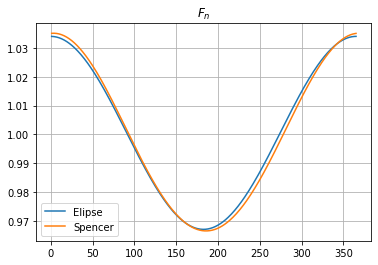

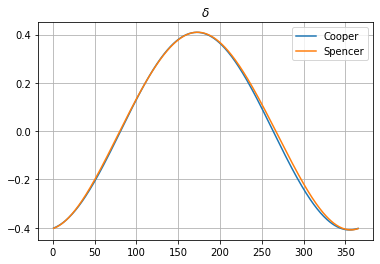

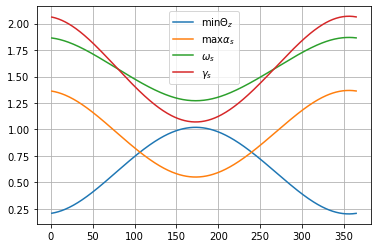

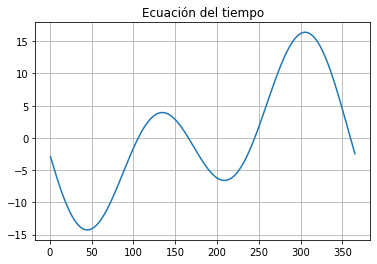

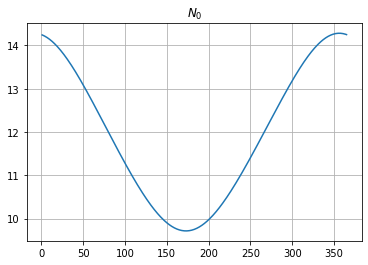

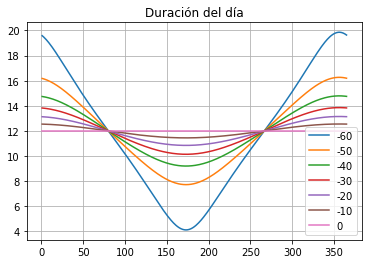

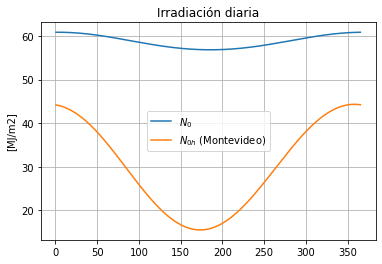

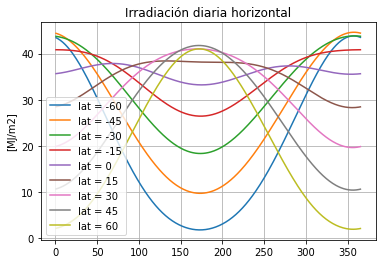

In [3]:
ns = list(range(1, 366)) # ¿Deberíamos haber usado NumPy?... ¡nah!
latitud = radians(-35)  # Tomamos Montevideo, como en las diapositivas.
longitud = radians(-56.2)
huso = -3

plt.plot(ns, [factor_correccion_orbital(n) for n in ns], label='Elipse')
plt.plot(ns, [factor_correccion_orbital_spencer(n) for n in ns], label='Spencer')
plt.legend()
plt.title('$F_n$')
plt.show()

plt.plot(ns, [declinacion_solar(n) for n in ns], label='Cooper')
plt.plot(ns, [declinacion_solar_spencer(n) for n in ns], label='Spencer')
plt.legend()
plt.title('$\delta$')
plt.show()

plt.plot(ns, [angulo_cenital_minimo(n, latitud) for n in ns], label='$\min\Theta_z$')
plt.plot(ns, [altura_solar_maxima(n, latitud) for n in ns], label='$\max\\alpha_s$')
plt.plot(ns, [angulo_horario_puesta_de_sol(n, latitud) for n in ns], label='$\omega_s$')
plt.plot(ns, [azimut_solar_puesta_de_sol(n, latitud) for n in ns], label='$\gamma_s$')
plt.legend()
plt.show()

plt.plot(ns, [ecuacion_del_tiempo_spencer(n) for n in ns])
plt.title('Ecuación del tiempo')
plt.show()

plt.plot(ns, [duracion_del_dia(n, latitud) for n in ns])
plt.title('$N_0$')
plt.show()

for lat in range(-60, 1, 10):
  plt.plot(ns, [duracion_del_dia(n, radians(lat)) for n in ns], label='%d' % lat)
plt.title('Duración del día')
plt.legend()
plt.show()

plt.plot(ns, [irradiacion_diaria_TOA_normal(n) for n in ns], label='$N_0$')
plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, latitud) for n in ns], label='$N_{0h}$ (Montevideo)')
plt.title('Irradiación diaria')
plt.ylabel('[MJ/m2]')
plt.legend()
plt.show()

for lat in range(-60, 61, 15):
  plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, radians(lat)) for n in ns], label='lat = %d' % lat)
plt.title('Irradiación diaria horizontal')
plt.ylabel('[MJ/m2]')
plt.legend()
plt.show()

Ejercicio 0 -- Parte b
----------------------

In [4]:
def angulo_cenital(n, omega, latitud):
  delta = declinacion_solar_spencer(n)
  return acos(sin(delta) * sin(latitud) + cos(delta) * cos(latitud) * cos(omega))

def altura_solar(n, omega, latitud):
  return pi / 2 - angulo_cenital(n, omega, latitud)

def sign(x):
  return copysign(1, x)

def angulo_acimutal(n, omega, latitud):
  delta = declinacion_solar_spencer(n)
  thetaz = angulo_cenital(n, omega, latitud)
  arg = (sin(delta) - cos(thetaz) * sin(latitud)) / (sin(thetaz) * cos(latitud))
  if(arg < -1): return -pi
  if(arg > 1): return 0
  return sign(omega) * abs(acos(arg))

def tiempo_estandar(n, omega, longitud, huso):
  return 12 * (1 + omega / pi) - degrees(longitud) / 15 + huso - ecuacion_del_tiempo_spencer(n) / 60

Equinoccio: [(80, -0.001150591501957688), (81, 0.005740992150424236)]
Solsticio: [(172, 0.40931542032971796), (173, 0.4093769016352889), (174, 0.4093177443428098)]
Equinoccio: [(266, 0.004342022176745865), (267, -0.0024503120898228025)]
Solsticio: [(355, -0.40875419804612767), (356, -0.40886151186277603), (357, -0.4088324041724486)]


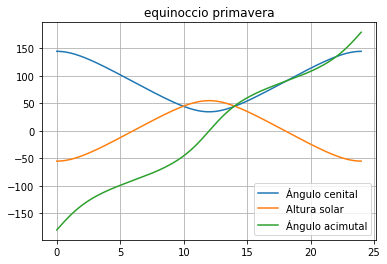

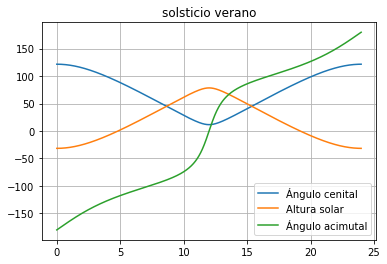

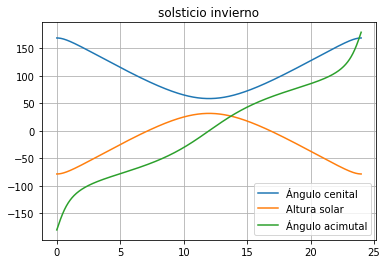

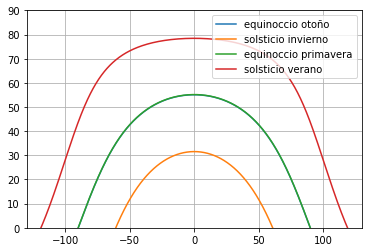

Mediodía en equinoccio otoño: 12:52:39
Mediodía en solsticio invierno: 12:46:20
Mediodía en equinoccio primavera: 12:36:47
Mediodía en solsticio verano: 12:43:05


In [5]:
hs = [m / 60 for m in range(60 * 24)]
omegas = [(h - 12) * pi / 12 for h in hs]

deltas = [(n, declinacion_solar_spencer(n)) for n in ns]
print('Equinoccio:', deltas[79:81])
print('Solsticio:', deltas[171:174])
print('Equinoccio:', deltas[265:267])
print('Solsticio:', deltas[354:357])

nsolsticios = {
    'equinoccio otoño': 80,
    'solsticio invierno': 173,
    'equinoccio primavera': 267,
    'solsticio verano': 356,
}

for k in ('equinoccio primavera', 'solsticio verano', 'solsticio invierno'):
  n = nsolsticios[k]
  plt.plot(hs, [degrees(angulo_cenital(n, omega, latitud)) for omega in omegas], label='Ángulo cenital')
  plt.plot(hs, [degrees(altura_solar(n, omega, latitud)) for omega in omegas], label='Altura solar')
  plt.plot(hs, [degrees(angulo_acimutal(n, omega, latitud)) for omega in omegas], label='Ángulo acimutal')
  plt.title(k)
  plt.legend()
  plt.show()

for nombre,n in nsolsticios.items():
  plt.plot(
      [degrees(angulo_acimutal(n, omega, latitud)) for omega in omegas],
      [degrees(altura_solar(n, omega, latitud)) for omega in omegas],
      label=nombre
      )
plt.axis([-130, 130, 0, 90])
plt.legend()
plt.show()

def tiempo_a_hms(t):
  h = int(t)
  m = (t - h) * 60
  s = int((m - int(m)) * 60)
  m = int(m)
  return h, m, s

for nombre,n in nsolsticios.items():
  tutc = tiempo_estandar(n, 0, longitud, huso)
  print('Mediodía en %s: %02d:%02d:%02d' % ((nombre, ) + tiempo_a_hms(tutc)))

Ejercicio 1
-----------

**Parte b**

(Varias de las cosas pedidas en este ejercicio ya están como parte de las pruebas del ejercicio 0.)

* Visualización: Pruebas 0-a.
* Días más corto y más largo:

Si consideramos horas de sol son los solsticios: n = 173, 356.

Si consideramos duración son los máximos y mínimos de la ecuación de tiempo:


In [6]:
es = [ecuacion_del_tiempo_spencer(n) for n in ns]
print('Mínimo: E(%d) = %f' % (es.index(min(es)) + 1, min(es))) # El +1 es porque los ns están en rango 1..365 y los índices en rango 0..364
print('Máximo: E(%d) = %f' % (es.index(max(es)) + 1, max(es)))

print('Duración mínima: %02d:%02d:%02d' % tiempo_a_hms(24 + min(es) / 60))
print('Duración máxima: %02d:%02d:%02d' % tiempo_a_hms(24 + max(es) / 60))

Mínimo: E(45) = -14.266350
Máximo: E(306) = 16.387239
Duración mínima: 23:45:44
Duración máxima: 24:16:23


* Irradiaciones máximas:

In [7]:
print('Irradiación máxima diaria TOA en Montevideo: %f MJ/m2' % max([irradiacion_diaria_TOA_horizontal(n, latitud) for n in ns]))
print('Irradiación máxima diaria TOA en lat +35: %f MJ/m2' % max([irradiacion_diaria_TOA_horizontal(n, -latitud) for n in ns]))

Irradiación máxima diaria TOA en Montevideo: 44.321566 MJ/m2
Irradiación máxima diaria TOA en lat +35: 41.465539 MJ/m2


Se observa que el $F_n$ es máximo durante el solsticio de verano austral y mínimo en el solsticio de verano boreal con una diferencia del orden del 7%, eso explicaría la diferencia.

**Parte b**

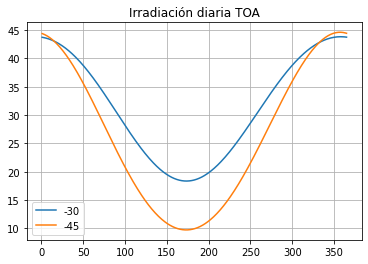

Duración máxima del día -30: 13.8557951299093
Duración máxima del día -45: 15.423438827920874


In [8]:
plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, radians(-30)) for n in ns], label='-30')
plt.plot(ns, [irradiacion_diaria_TOA_horizontal(n, radians(-45)) for n in ns], label='-45')
plt.title('Irradiación diaria TOA')
plt.legend()
plt.show()

print('Duración máxima del día -30:', max([duracion_del_dia(n, radians(-30)) for n in ns]))
print('Duración máxima del día -45:', max([duracion_del_dia(n, radians(-45)) for n in ns]))

Se cree que la mayor radiación recibida en el solsticio de verano se corresponde con la duración del día que es de casi 2 horas adicionales y compensa el menor ángulo de elevación solar.

**Parte c**

In [9]:
departamentos = {
    'Rocha': (-33.74, -53.37),
    'Trenta y Tres': (-32.83, -53.29),
    'Cerro Largo': (-32.71, -53.18)
}

for nombre,coordenadas in departamentos.items():
  lat, lon = (radians(x) for x in coordenadas)
  omegaamanecer = [(n, -angulo_horario_puesta_de_sol(n, lat)) for n in ns]
  tiempoamanecer = [tiempo_estandar(n, omega, lon, huso) for (n, omega) in omegaamanecer]
  print('En %s amanece a las %02d:%02d:%02d' % ((nombre, ) + tiempo_a_hms(min(tiempoamanecer))))

En Rocha amanece a las 05:22:39
En Trenta y Tres amanece a las 05:24:34
En Cerro Largo amanece a las 05:24:24


Se buscó el valor del amanecer en hora local más temprano del año para cada sitio.

Para sorpresa de nadie, amanece antes en el sitio más al este.

Cabe destacar que el menor ángulo horario se da el 31/12, no sé si no hay algún error en cómo lo comprobé.

Ejercicio 2
-----------

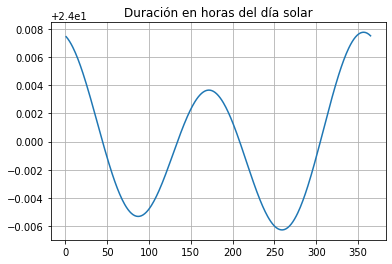

In [10]:
mediodias = [tiempo_estandar(n, 0, longitud, huso) for n in ns]
duraciones = []
for i in range(len(mediodias)):
  duraciones.append(mediodias[(i + 1) % len(mediodias)] - mediodias[i] + 24)

plt.plot(ns, duraciones)
plt.title('Duración en horas del día solar')
plt.show()


Puede verse que como lo que se comparan son las horas entre los mediodías solares de dos días consecutivos termina siendo la derivada de la ecuación del tiempo $E$.

Los días que duran exactamente 24 horas se corresponden con los máximos y mínimos de $E$, que es cuando la corrección con respecto a la cantidad de horas es la misma en dos días consecutivos.

Ejercicio 3
-----------

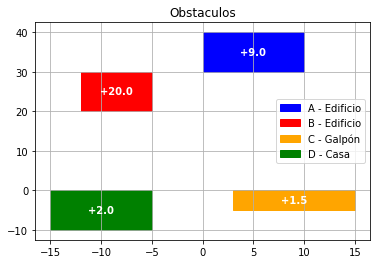

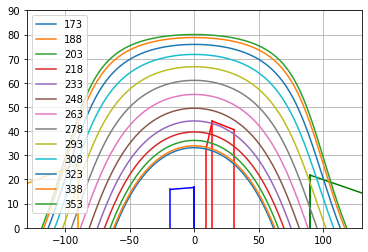

In [11]:
lat = radians(-33.382)
lon = radians(-56.523)

obstaculos = {
    'A - Edificio': (0, 30, 10, 40, 9, 'blue'),
    'B - Edificio': (-5, 20, -12, 30, 20, 'red'),
    'C - Galpón': (3, 0, 15, -5, 1.5, 'orange'),
    'D - Casa': (-5, 0, -15, -10, 2, 'green'),
}

fig = plt.figure()
ax = fig.add_subplot(111)

for k,v in obstaculos.items():
  x0, y0, x1, y1, z, c = v
  ax.add_patch(matplotlib.patches.Rectangle((x0, y0), x1 - x0, y1 - y0, color=c, label=k))
  plt.text((x0 + x1) / 2, (y0 + y1) / 2, '+%.1f' % z, color='white', fontweight='bold', horizontalalignment='center', verticalalignment='center')

plt.title('Obstaculos')
plt.legend()
plt.plot()
plt.show()


for k,v in obstaculos.items():
  x0, y0, x1, y1, z, c = v
  ps = []

  for x,y in ((x1, y0), (x0, y0), (x0, y1)):
    d = (x ** 2 + y ** 2) ** .5
    omega = degrees(atan2(-x, y)) # Invierto x e y pero es correcto, -x por convención este-oeste
    alpha = degrees(atan2(z, d))
    ps.append((omega, alpha))

  p0, p1, p2 = ps
  plt.plot((p0[0], p0[0]), (0, p0[1]), color=c)
  plt.plot((p1[0], p1[0]), (0, p1[1]), color=c)
  plt.plot((p2[0], p2[0]), (0, p2[1]), color=c)
  plt.plot((p0[0], p1[0]), (p0[1], p1[1]), color=c)
  plt.plot((p1[0], p2[0]), (p1[1], p2[1]), color=c)


for n in range(nsolsticios['solsticio invierno'], nsolsticios['solsticio verano'], 15):
  plt.plot(
      [degrees(angulo_acimutal(n, omega, lat)) for omega in omegas],
      [degrees(altura_solar(n, omega, lat)) for omega in omegas],
      label='%d' % n
      )
plt.axis([-130, 130, 0, 90])
plt.legend()
plt.show()

En principio los obstáculos más preocupantes van a ser siempre los que estén al norte y cercanos. Los objetos que se ecuentran al sur sólo van a hacer sombra en los amaneceres/atardeceres del verano. En cuanto a los objetos al norte importa la altura y la distancia; objetos o bajos o a larga distancia no van a hacer sombra dado que incluso en el invierno el sol les pasará por arriba.

En este caso puede verse que el edificio de 9 metros de altura que se encuentra a 30 metros no hace sombra en ningún momento del año. Incluso aunque tuviera el doble de esa altura no lo haría.

En cambio el de 20 metros ubicado a poco más de 20 metros hace sombra aproximadamente 120 días al año (aproximadamente 60 días después del solsticio según el gráfico). El edificio este tiene de ancho 16 grados entre sus dos lados, por lo que la sombra será aproximadamente 1 hora al día.

Ejercicio 4
-----------

In [12]:
def inversa_tiempo_estandar(n, tutc, longitud, huso):
  return pi * ((tutc + ecuacion_del_tiempo_spencer(n) / 60 - huso + degrees(longitud) / 15) / 12 - 1)

assert(inversa_tiempo_estandar(100, tiempo_estandar(100, 0, longitud, huso), longitud, huso) == 0)

count    8.376000e+03
mean    -7.523605e-07
std      4.199722e-05
min     -6.786757e-05
25%     -4.074599e-05
50%     -8.610933e-07
75%      3.900785e-05
max      6.784389e-05
Name: error_cz, dtype: float64


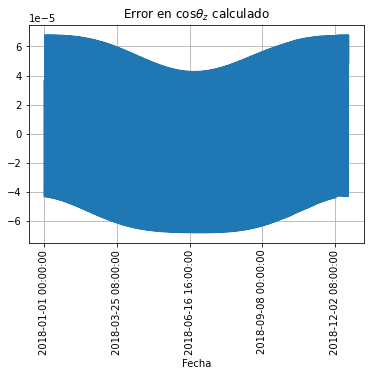

In [13]:
import os
import pandas as pd

lblat = radians(-34.67)
lblon = radians(-56.34)

lb = pandas.read_csv('LB_2018_completo.csv', index_col='Fecha')

#print(lb.describe())

def computar_cz(row):
  n = row['N']
  nr = row['NR']
  omega = inversa_tiempo_estandar(n, nr - 0.5, lblon, huso)
  return cos(angulo_cenital(n, omega, lblat))

lb['cz_computado'] = lb.apply(computar_cz, axis=1)
lb['error_cz'] = lb['CZ'] - lb['cz_computado']

print(lb['error_cz'].describe())
lb['error_cz'].plot()
plt.title('Error en $\cos\\theta_z$ calculado')
plt.xticks(rotation = 90)
plt.show()
  

Las diferencias entre el $\cos\theta_z$ del CSV versus el calculado son ínfimas.

**Observación:** Se restaron 30 minutos a las etiquetas temporales cuando el enunciado decía que las mismas estaban al inicio, esto correspondería para etiquetas al final.

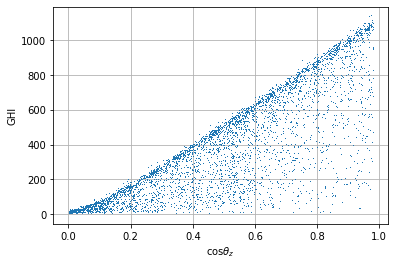

In [14]:
lbdiurnas = lb[lb['CZ'] > 0]
plt.plot(lbdiurnas['CZ'], lbdiurnas['GHI1'], ',')
plt.ylabel('GHI')
plt.xlabel('$\cos\\theta_z$')
plt.show()


El gráfico muestra una buena consistencia entre el CZ y el desplazamiento solar y valores esperables.

Modelo de cielo claro:

In [34]:
TL_SUR = [3.037, 2.964, 2.839, 2.659, 2.568, 2.434, 2.45, 2.56, 2.722, 2.729, 2.908, 2.963]

# Uso regla de Horner para evitar potencias en los polinomios, perdón.

def masa_de_aire(cz):
  """Fórmula de Young"""
  return ((1.002432 * cz + 0.148386) * cz + 0.0096467) / \
    (((cz + 0.149864) * cz + 0.0102963) * cz + 0.000303978)

def inv_kr(m):
  if m > 20:
    return 10.6 + 0.718 * m

  return (((-0.00013 * m + 0.00650) * m -0.12020) * m + 1.75130) * m + 6.62960

def irradiancia_TOA(n):
  """$G_0$"""
  return GS * factor_correccion_orbital_spencer(n)

def irradiancia_directa_superficie_horizontal(n, cz, tl):
  """$G_{bh,c}$"""
  m = masa_de_aire(cz)
  return irradiancia_TOA(n) * cz * exp(-m * tl / inv_kr(m))

def factor_transmitancia_difusa(tl):
  """$T_z(T_L)$"""
  return (3.797e-4 * tl + 3.0543e-2) * tl - 1.5843e-2

def modificador_angular_difusa(cz, tl):
  """$F_d(\theta_z, T_L)$"""
  a0 = (3.1408e-3 * tl - 6.1581e-2) * tl + 2.6463e-1
  a1 = (-1.1161e-2 * tl + 1.8945e-2) * tl + 2.0402
  a2 = (8.5079e-3 * tl + 3.9231e-2) * tl - 1.3025

  return (a2 * cz + a1) * cz + a0

def irradiancia_difusa_ESRA(n, cz, tl):
  tl = tl / 0.8665
  return irradiancia_TOA(n) * factor_transmitancia_difusa(tl) * modificador_angular_difusa(cz, tl)

def ghi_cielo_claro(n, cz, tl):
  if cz < 0: return 0
  return irradiancia_directa_superficie_horizontal(n, cz, tl) + irradiancia_difusa_ESRA(n, cz, tl)

Validación parámetros del modelo de cielo claro:

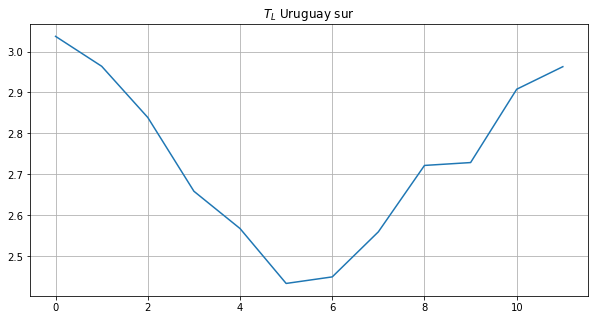

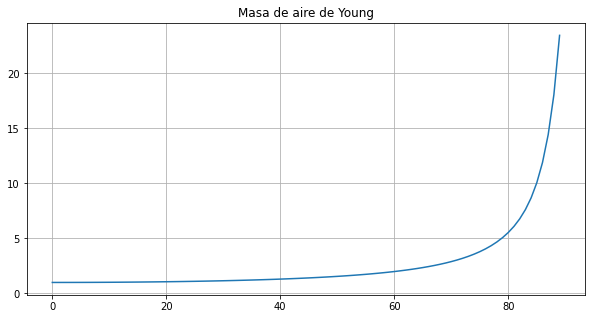

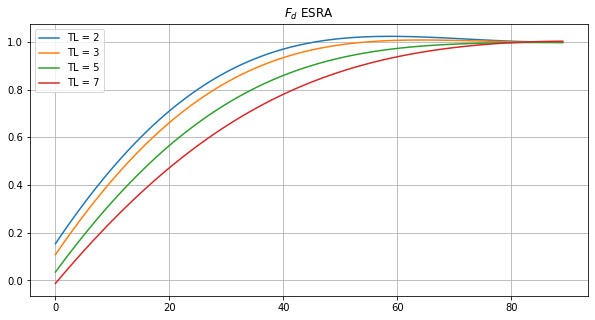

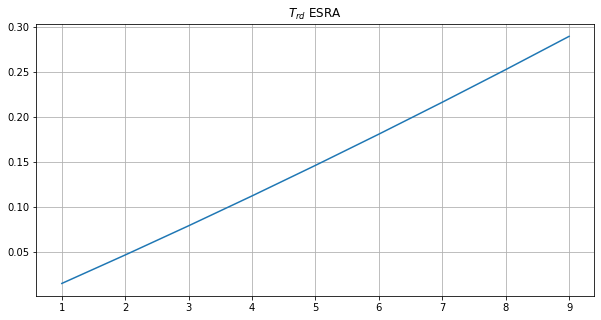

In [33]:
plt.plot(TL_SUR)
plt.title('$T_L$ Uruguay sur')
plt.show()

zs = range(90)
plt.plot(zs, [masa_de_aire(cos(radians(z))) for z in zs])
plt.title('Masa de aire de Young')
plt.show()

for tl in (2, 3, 5, 7):
  plt.plot(zs, [modificador_angular_difusa(cos(radians(90-z)), tl) for z in zs], label='TL = %d' % tl)
plt.legend()
plt.title('$F_d$ ESRA')
plt.show()

tls = range(1, 10)
plt.plot(tls, [factor_transmitancia_difusa(tl) for tl in tls])
plt.title('$T_{rd}$ ESRA')
plt.show()

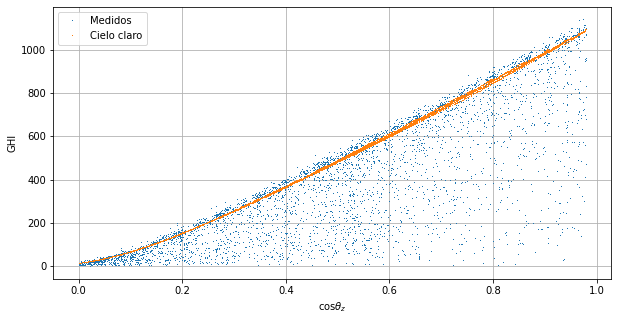

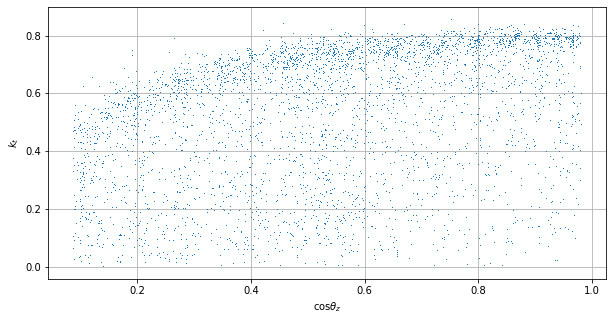

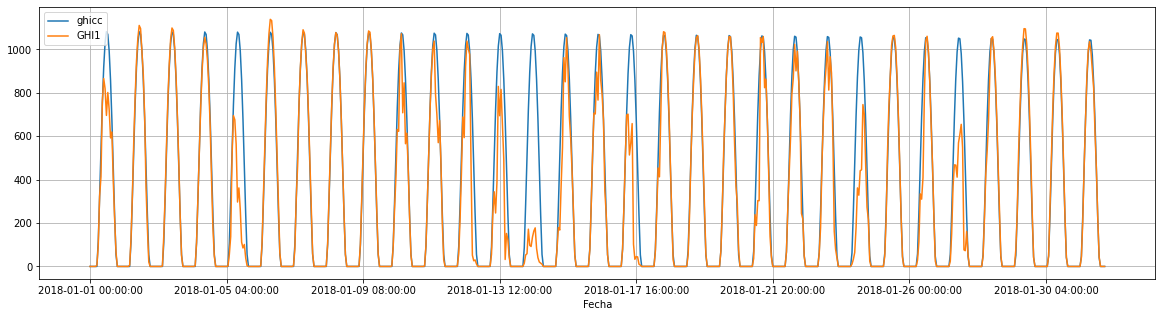

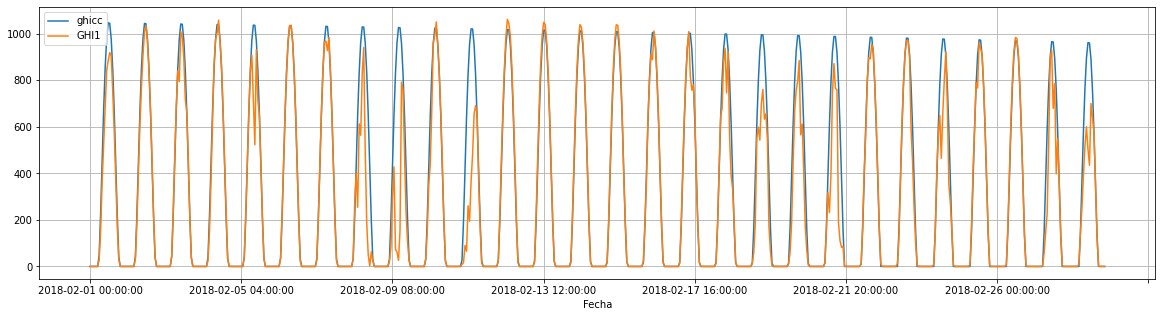

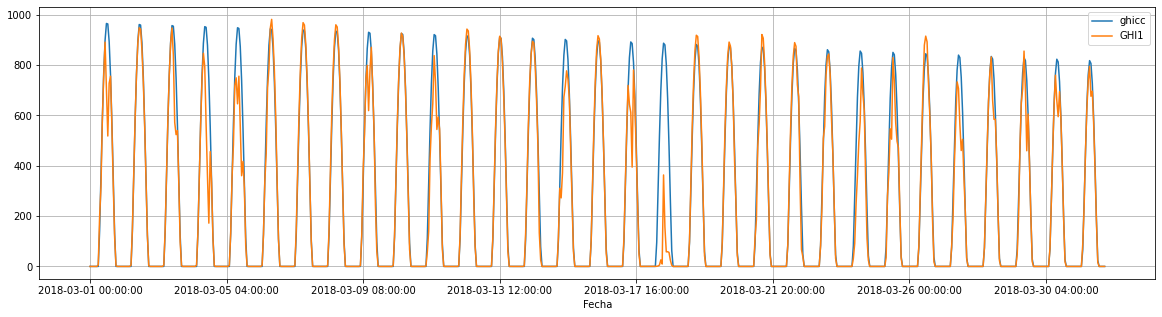

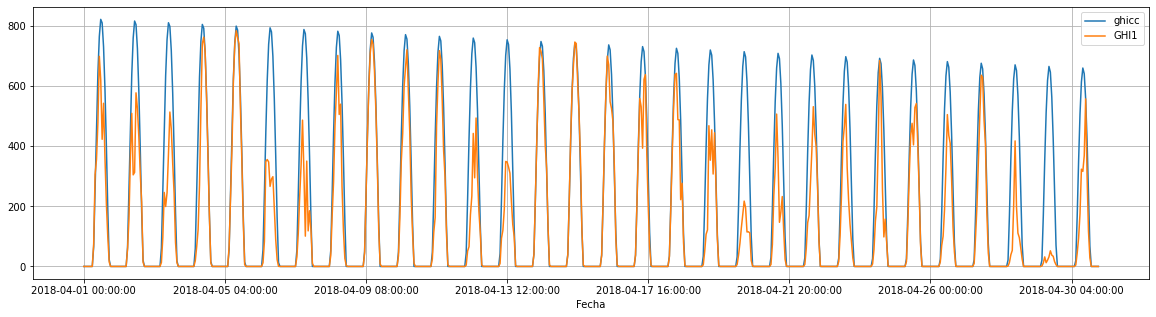

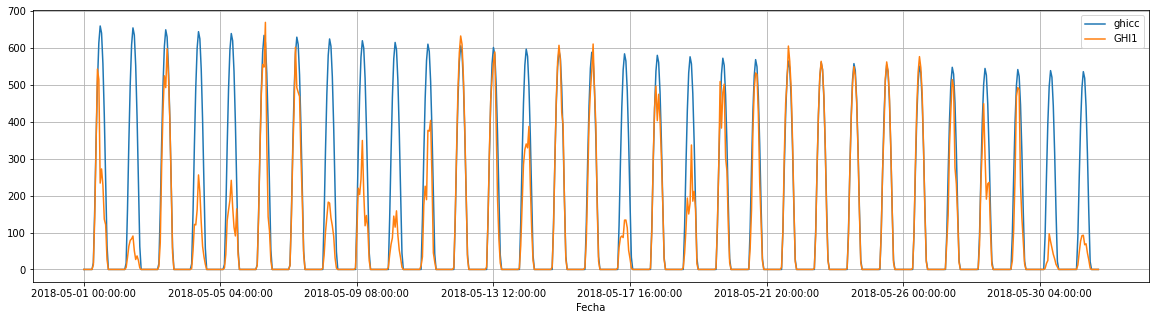

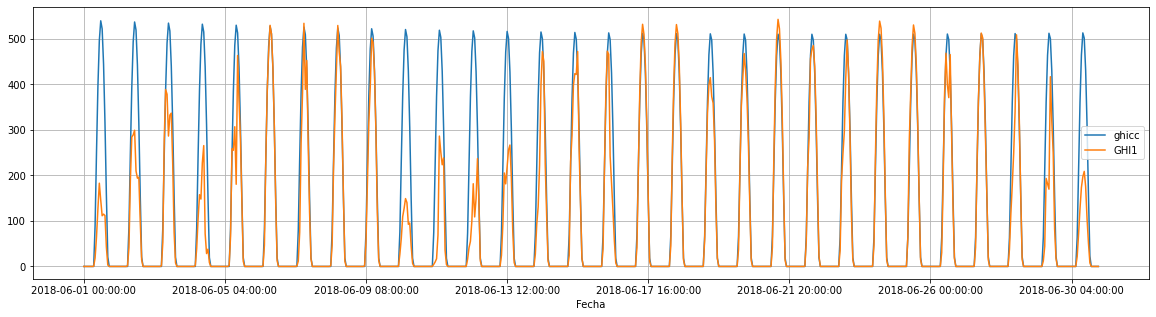

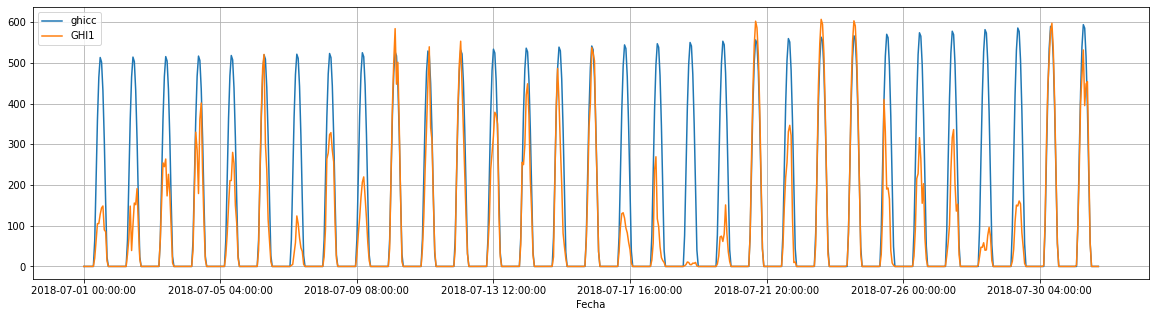

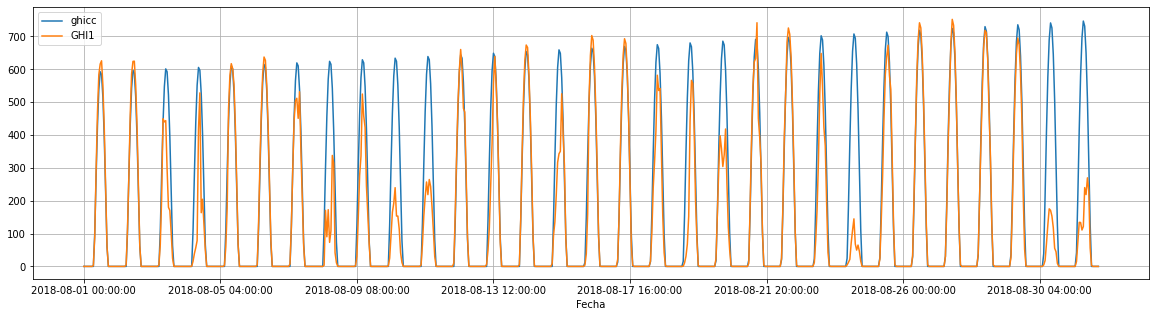

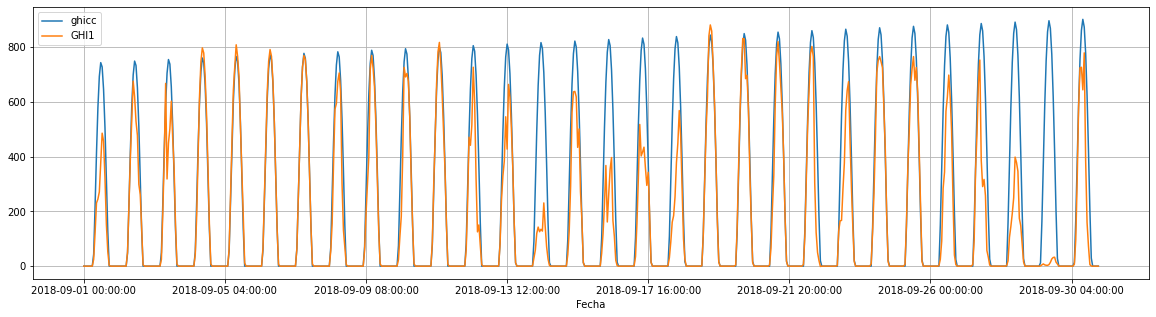

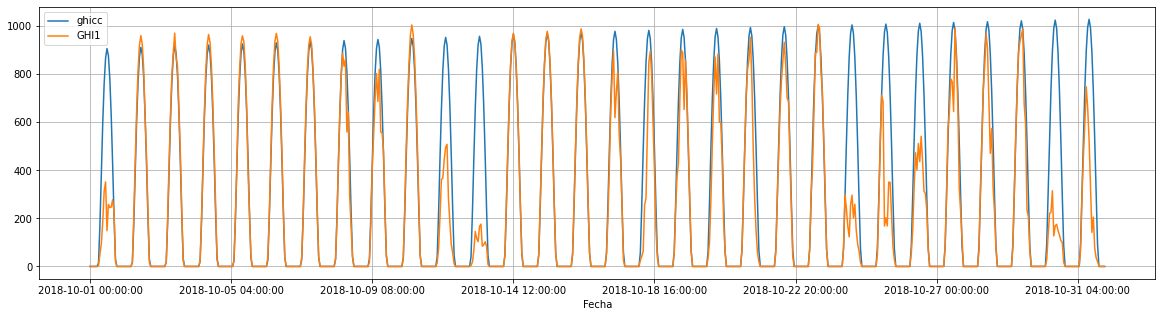

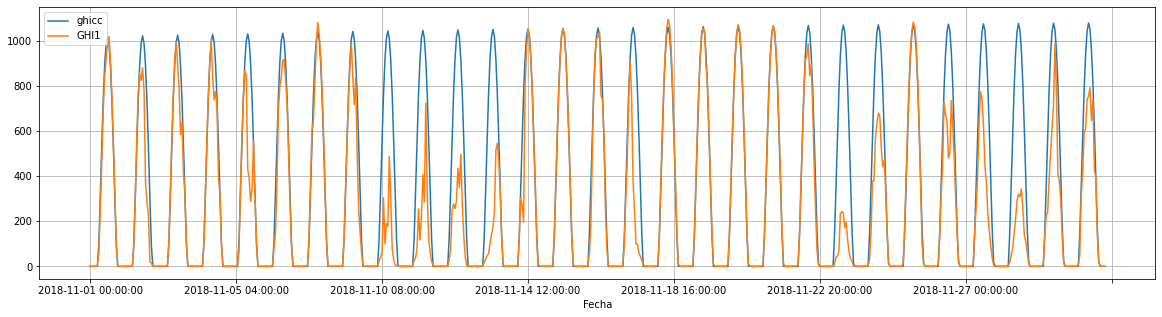

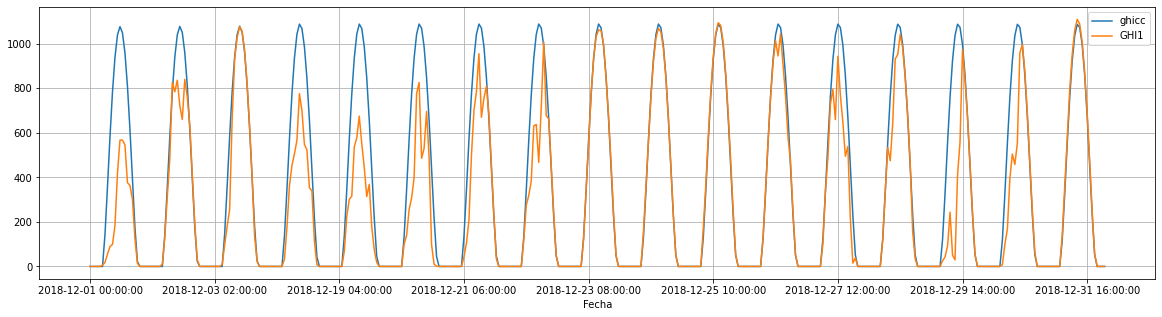

In [43]:
lb['ghicc'] = lb.apply(computar_ghi, axis=1)
lbdiurnas = lb[lb['CZ'] > 0]

plt.plot(lbdiurnas['CZ'], lbdiurnas['GHI1'], ',', label='Medidos')
plt.plot(lbdiurnas['CZ'], lbdiurnas['ghicc'], ',', label='Cielo claro')
plt.ylabel('GHI')
plt.xlabel('$\cos\\theta_z$')
plt.legend()
plt.show()

lb['goh'] = lb['N'].apply(irradiancia_TOA) * lb['CZ']
lb['kt'] = lb['GHI1'] / lb['goh']

lbmayor5 = lb[lb['CZ'] > sin(radians(5))]
plt.plot(lbmayor5['CZ'], lbmayor5['kt'], ',')
plt.ylabel('$k_t$')
plt.xlabel('$\cos\\theta_z$')
plt.show()

plt.rcParams['figure.figsize'] = (20, 5)
for mes in range(1, 13):
  # Llegado a este punto es donde me pregunto por qué no importé las fechas como datetime...
  lb['ghicc']['2018-%02d-01' % mes:'2018-%02d-01' % (mes + 1)].plot()
  lb['GHI1']['2018-%02d-01' % mes:'2018-%02d-01' % (mes + 1)].plot()
  plt.legend()
  plt.show()
plt.rcParams['figure.figsize'] = figsize

Podemo elegir el día 23/12, el 21/06 y el 2/10 como días completamente despejados lo más cercanos al solsticio de verano, invierno y al equinoccio de primavera respectivamente.

Cabe destacar que los días de primavera vienen complicados en la serie dada, incluso el día elegido parece tener una ligera baja en la GHI a las 15:00 hs.

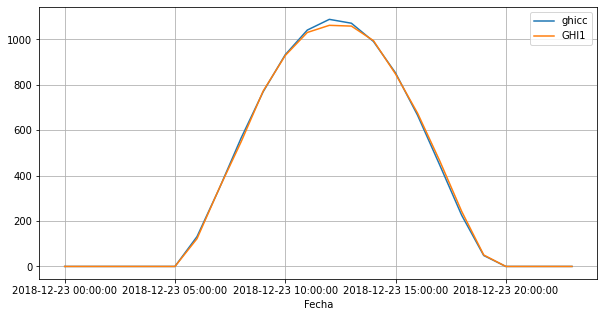

MBD: 2.373725
RMSD: 12.701860


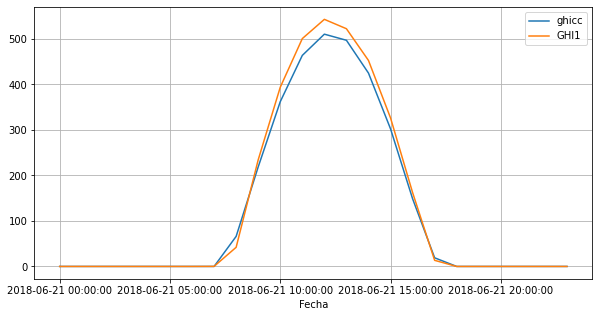

MBD: -20.389035
RMSD: 26.717319


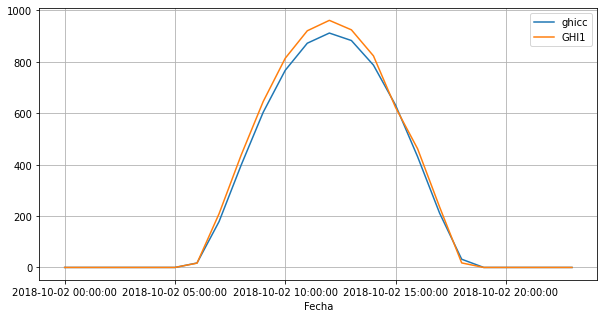

MBD: -34.436566
RMSD: 37.857421


In [77]:
nverano = lb['N']['2018-12-23 12:00:00']
ninvierno = lb['N']['2018-06-21 12:00:00']
nprimavera = lb['N']['2018-10-02 12:00:00']

for n in (nverano, ninvierno, nprimavera):
  dia = lb[lb['N'] == n]
  dia['ghicc'].plot()
  dia['GHI1'].plot()
  plt.legend()
  plt.show()

  dia = dia[dia['CZ'] > sin(radians(5))]
  err = dia['ghicc'] - dia['GHI1']

  # Estos estadísticos ya vienen en Pandas, pero los implemento según la ecuación
  print('MBD: %f' % (sum(err) / len(err)))
  print('RMSD: %f' % ((sum(err.apply(lambda x: x ** 2)) / len(err)) ** .5))


